<a href="https://colab.research.google.com/github/Yashu2699/Deep_learning/blob/main/Semantic_seg/watershed_instance_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

files.upload()

Saving unet.py to unet.py


{'unet.py': b'# -*- coding: utf-8 -*-\n"""UNET\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1I_HfLG9bxK6dUy48IOz7U4va_nK27WHh\n"""\n\nfrom keras.models import Model\nfrom keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda\n\n\ndef simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):\n    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))\n    s = inputs\n\n    c1 = Conv2D(16, (3, 3), activation=\'relu\', kernel_initializer=\'he_normal\', padding=\'same\')(s)\n    c1 = Dropout(0.1)(c1)\n    c1 = Conv2D(16, (3, 3), activation=\'relu\', kernel_initializer=\'he_normal\', padding=\'same\')(c1)\n    p1 = MaxPooling2D((2, 2))(c1)\n    \n    c2 = Conv2D(32, (3, 3), activation=\'relu\', kernel_initializer=\'he_normal\', padding=\'same\')(p1)\n    c2 = Dropout(0.1)(c2)\n    c2 = Conv2D(32, (3, 3), activation=\'relu\', kernel_initializer=\'

In [3]:
import unet
from unet import simple_unet_model

In [6]:
from keras.models import load_model

In [14]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, color, io

In [15]:
height = 256
width = 256
channels = 1

def get_model():
  return simple_unet_model(height, width, channels)

model = get_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [16]:
model.load_weights('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/models/microscopy_unet.hdf5')

In [26]:
test_img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/test_images/test_image_3_10.tif', 0)

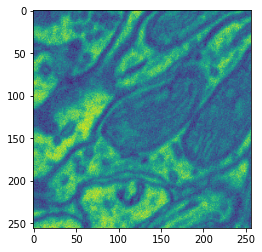

In [27]:
plt.imshow(test_img)

In [28]:
img = np.array(test_img)
img.shape

(256, 256)

In [29]:
test_img_norm = np.expand_dims(normalize(np.array(test_img), axis=1), 2)
test_img_norm.shape

(256, 256, 1)

In [30]:
test_img_norm = test_img_norm[:,:,0][:,:,None]
test_img_norm.shape

(256, 256, 1)

In [31]:
test_img_input = np.expand_dims(test_img_norm, 0)
test_img_input.shape

(1, 256, 256, 1)

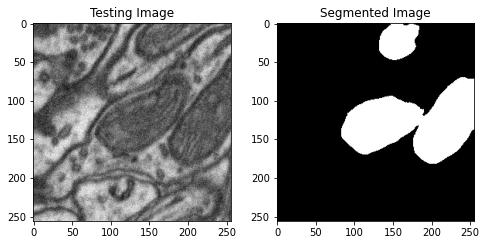

In [33]:
segmented_img = (model.predict(test_img_input)[0,:,:,0]>0.05).astype(np.uint8)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(222)
plt.title('Segmented Image')
segmented_img = (model.predict(test_img_input)[0,:,:,0]>0.01).astype(np.uint8)
plt.imshow(segmented_img, cmap='gray')
plt.show()

In [37]:
seg_img = np.expand_dims(segmented_img, axis=2)
seg_img.shape

(256, 256, 1)

## Watershed Instance segmentation

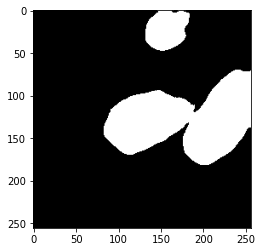

In [68]:
seg_img = cv2.cvtColor(seg_img,cv2.COLOR_GRAY2RGB)
img_gray = seg_img[:,:,0]
plt.imshow(img_gray, cmap='gray')

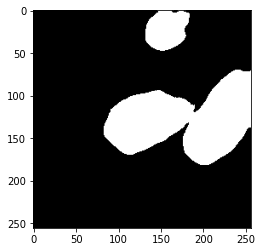

In [69]:
ret1, img_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(img_otsu, cmap='gray')

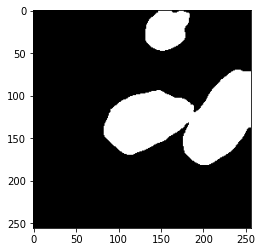

In [70]:
kernel = np.ones((3,3), np.uint8)
img_noiseless = cv2.morphologyEx(img_otsu, cv2.MORPH_OPEN, kernel, iterations=2)
plt.imshow(img_noiseless, cmap='gray')

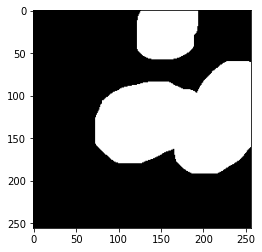

In [71]:
sure_bg = cv2.dilate(img_noiseless, kernel, iterations=10)
plt.imshow(sure_bg, cmap='gray')

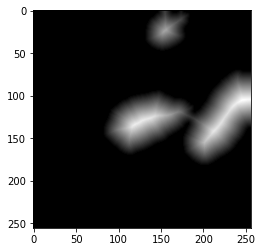

In [72]:
dist_trans = cv2.distanceTransform(img_noiseless, cv2.DIST_L2, 5)
plt.imshow(dist_trans, cmap='gray')

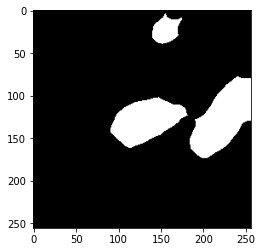

In [73]:
ret2, sure_fg = cv2.threshold(dist_trans, 0.25*dist_trans.max(), 255, 0)
plt.imshow(sure_fg, cmap='gray')

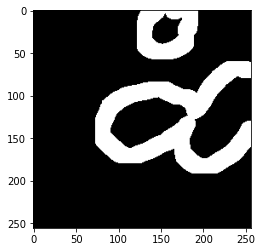

In [74]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

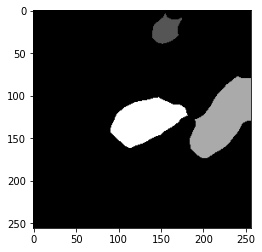

In [75]:
ret3, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers, cmap='gray')

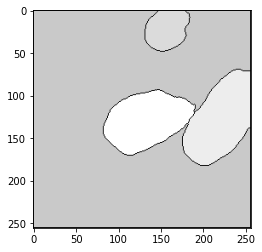

In [78]:
markers = markers + 10
plt.imshow(markers, cmap='gray')

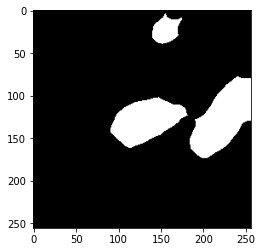

In [79]:
markers[unknown==255] = 0
plt.imshow(sure_fg, cmap='gray')
watershed = cv2.watershed(seg_img, markers)

In [80]:
seg_img[markers == -1] = [0,255,255]
img2 = color.label2rgb(markers, bg_label=0)

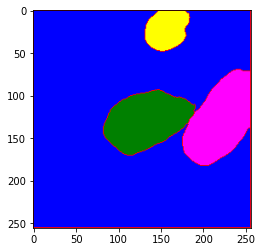

In [83]:
plt.imshow(img2)